In [2]:
cd ..

/home/ikboljonsobirov/uncertainty-benchmark/experiments


In [3]:
import medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from models.models_mcd import ResNet18_MCD, ResNet50_MCD

from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter
from utils.utils import Transform3D, model_to_syncbn
import os

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/231228_131656_resnet18mcd/best_model.pth'
# checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/nodulemnist3d/231228_122254_resnet18mcd/best_model.pth'

data_flag = 'organmnist3d'
# data_flag = 'nodulemnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
n_channels = info['n_channels']
n_classes = len(info['label'])

# load the data
train_dataset = DataClass(split='train',  download=download)
val_dataset = DataClass(split='val',  download=download)
test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz


In [6]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    total_output = 0
    
    with torch.no_grad():
        for i in range(num_samples):
            for data, _ in data_loader:
                data = data.to(device)
                output = model(data)
                total_output += output

    return total_output / num_samples

# Perform MC Dropout inference
model = ResNet18_MCD(in_channels=n_channels, num_classes=n_classes)
model = model_to_syncbn(ACSConverter(model))

model.to(device)
model = model.double()
model.load_state_dict(torch.load(checkpoint_path)['net'])

# mc_output = mc_dropout_inference(model, test_loader, num_samples=5)

<All keys matched successfully>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import torch.nn.functional as F


In [8]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    all_outputs = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            outputs = [model(data).detach().cpu().numpy() for _ in range(num_samples)]

            all_outputs.append(np.array(outputs))


    return all_outputs #np.mean(all_outputs, axis=0), np.std(all_outputs, axis=0)

# Perform MC Dropout inference
all_outputs = mc_dropout_inference(model, test_loader, num_samples=5)


In [9]:
# Concatenating along the second dimension
concatenated_output = np.concatenate(all_outputs, axis=1)
# apply softmax to the concatenated output
concatenated_output = F.softmax(torch.tensor(concatenated_output), dim=2)
# Checking the shape of the concatenated output
concatenated_output.shape


torch.Size([5, 610, 11])

In [10]:
mc_mean, mc_uncertainty = torch.mean(concatenated_output, axis=0), torch.std(concatenated_output, axis=0)

In [11]:
mc_mean[0]

tensor([4.7221e-04, 2.8196e-09, 2.0457e-08, 2.9675e-08, 4.5129e-05, 1.3037e-05,
        5.6442e-05, 1.4805e-07, 2.5826e-06, 1.5055e-04, 9.9926e-01],
       dtype=torch.float64)

In [12]:
mc_uncertainty[0]

tensor([4.8427e-04, 1.9817e-09, 1.9700e-08, 1.7317e-08, 3.5851e-05, 1.3209e-05,
        1.8046e-05, 6.3170e-08, 1.1525e-06, 1.3119e-04, 6.4052e-04],
       dtype=torch.float64)

In [13]:
targets = []
for _, target in test_loader:
    target = target.numpy()
    print(target.shape)
    targets.append(target)

(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(2, 1)


In [14]:
targets  = np.concatenate(targets, axis=0)

In [15]:
mc_mean

tensor([[4.7221e-04, 2.8196e-09, 2.0457e-08,  ..., 2.5826e-06, 1.5055e-04,
         9.9926e-01],
        [1.8591e-10, 8.5329e-06, 9.9999e-01,  ..., 1.7972e-09, 2.2600e-07,
         6.2539e-08],
        [1.9640e-07, 9.3533e-06, 1.1393e-05,  ..., 1.0308e-07, 1.1147e-05,
         3.3715e-07],
        ...,
        [1.1240e-07, 1.7556e-04, 4.4987e-05,  ..., 1.2124e-08, 7.0467e-07,
         3.4171e-08],
        [1.5800e-01, 1.3907e-01, 7.6978e-04,  ..., 7.6811e-04, 3.8610e-03,
         6.3672e-04],
        [2.0149e-03, 2.1005e-04, 1.7309e-01,  ..., 4.6752e-03, 5.8669e-01,
         1.1385e-01]], dtype=torch.float64)

In [16]:
total_f1 = f1_score(targets, np.argmax(mc_mean, axis=1), average='macro')
total_f1

0.939500870939327

0 0.001 0.9295081967213115
6 0.01108080808080808 0.9321192052980133
12 0.021161616161616163 0.9414715719063546
19 0.031242424242424245 0.9475465313028765
25 0.041323232323232324 0.9555555555555556
31 0.0514040404040404 0.9585492227979274
37 0.06148484848484849 0.9598603839441536
43 0.07156565656565657 0.9611992945326279
49 0.08164646464646465 0.966131907308378
55 0.09172727272727273 0.9675675675675676
62 0.1018080808080808 0.9726277372262774
68 0.11188888888888888 0.977859778597786
74 0.12196969696969698 0.9794776119402985
80 0.13205050505050506 0.9811320754716981
86 0.14213131313131314 0.9809160305343512
92 0.15221212121212122 0.9826254826254827
98 0.1622929292929293 0.984375
105 0.17237373737373737 0.9881188118811881
111 0.18245454545454545 0.9879759519038076
117 0.19253535353535353 0.9878296146044625
123 0.2026161616161616 0.9897330595482546
129 0.2126969696969697 0.9896049896049897
135 0.22277777777777777 0.991578947368421
142 0.23285858585858585 0.9914529914529915
148 0.2429393939

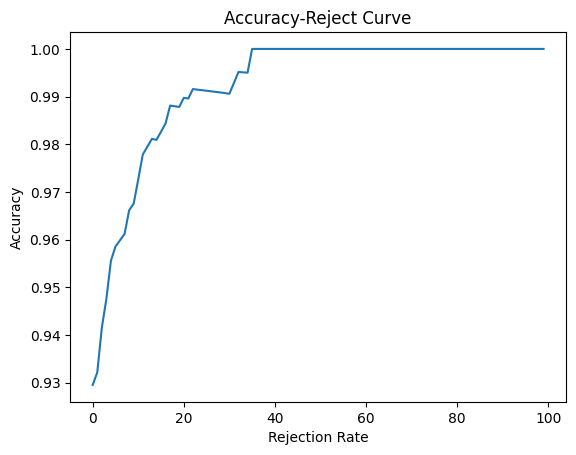

In [17]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    sorted_indices = np.argsort(predicted_class_uncertainty).numpy()[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [18]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    indices_to_keep = np.argsort(predicted_class_uncertainty).numpy()[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


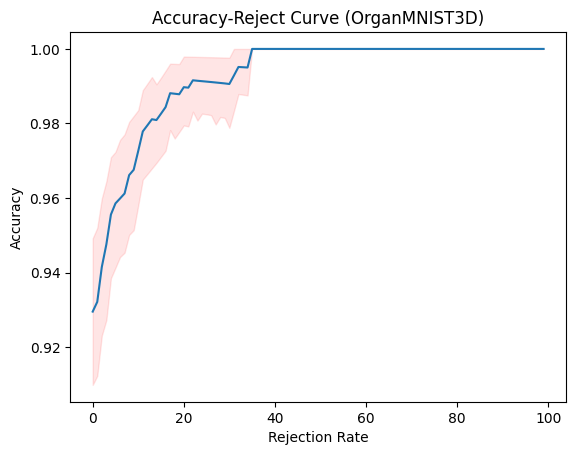

In [19]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


In [20]:
# lets get the area under this curve
from sklearn.metrics import auc
auc(rejection_rates, accuracies)

0.9904900811019584

### Use Entropy as the Uncertainty Metric

In [21]:
from scipy.stats import entropy

entropies = np.array([entropy(mean_prediction) for mean_prediction in mc_mean])
entropies.shape

(610,)

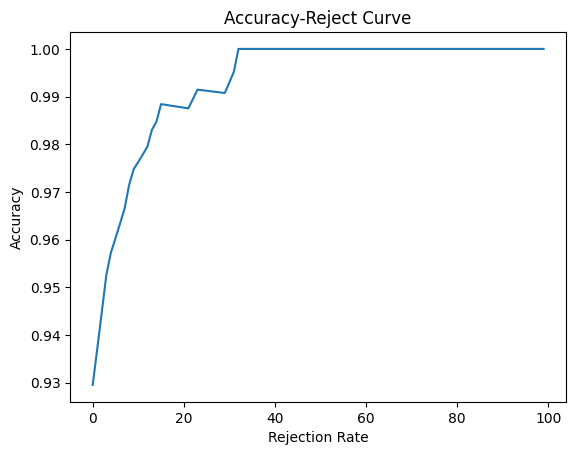

In [22]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
# predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(entropies) * rejection_rate)
    sorted_indices = np.argsort(entropies)[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    # print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [23]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(entropies) * rejection_rate)
    indices_to_keep = np.argsort(entropies)[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


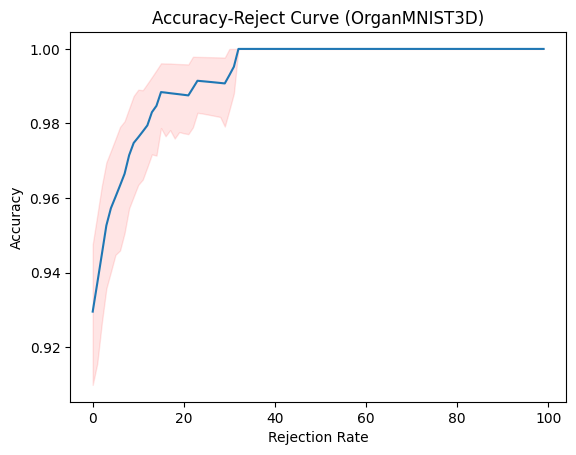

In [24]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


### Use Confidence as the Uncertainty Metric

In [25]:
confidences = np.max(mc_mean.numpy(), axis=1)
confidences.shape

(610,)

609 0.001 0.9310344827586207
609 0.011070707070707071 0.9386401326699834
609 0.02114141414141414 0.9430485762144054
609 0.031212121212121212 0.9525423728813559
609 0.04128282828282828 0.9606164383561644
609 0.05135353535353535 0.9636678200692042
609 0.06142424242424242 0.9685314685314685
609 0.0714949494949495 0.9734982332155477
609 0.08156565656565656 0.9767857142857143
609 0.09163636363636363 0.9765342960288809
609 0.1017070707070707 0.9762340036563071
609 0.11177777777777778 0.9796672828096118
609 0.12184848484848484 0.9794392523364486
609 0.1319191919191919 0.9810964083175804
609 0.141989898989899 0.9866156787762906
609 0.15206060606060606 0.9864603481624759
609 0.16213131313131313 0.9882583170254403
609 0.1722020202020202 0.9880952380952381
609 0.18227272727272725 0.9879518072289156
609 0.19234343434343434 0.9878048780487805
609 0.2024141414141414 0.9876543209876543
609 0.21248484848484847 0.9895833333333334
609 0.22255555555555556 0.989451476793249
609 0.23262626262626263 0.98931

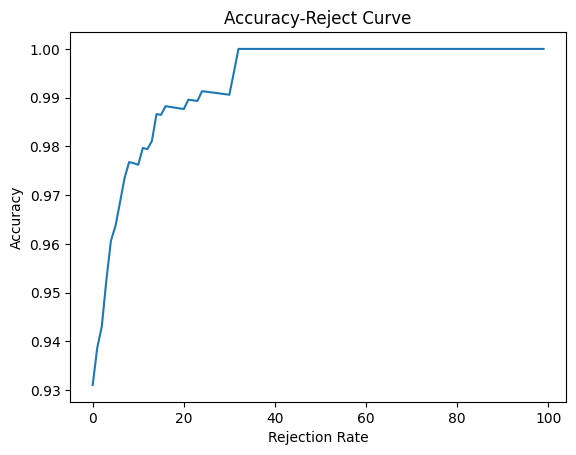

In [26]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
# predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.998, 100)


for rejection_rate in rejection_rates:
    num_keep = int(len(confidences) * (1 - rejection_rate))
    indices_to_keep = np.argsort(confidences)[-num_keep:]

    # indices_to_keep = sorted_indices[num_keep:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = np.argmax(mc_mean, axis=1)[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [27]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_keep = int(len(confidences) * (1 - rejection_rate))
    indices_to_keep = np.argsort(confidences)[-num_keep:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


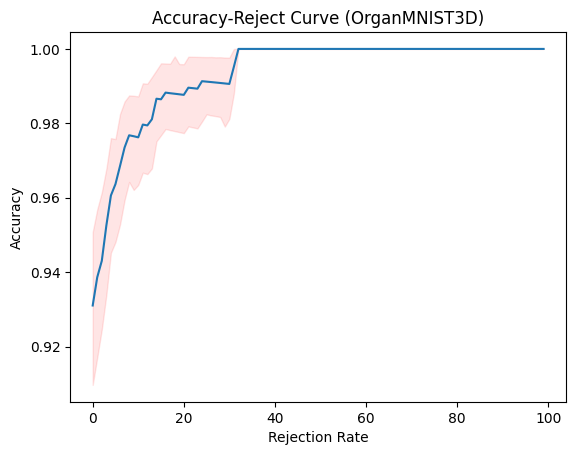

In [28]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()
